In [2]:
import nltk
nltk.download('wordnet')

from nltk.corpus import wordnet
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn import tree

[nltk_data] Downloading package wordnet to /root/nltk_data...


# Paso 1: Recopilación y preparación de los datos


In [3]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab/Colab Archive/2020-07-20/BERT_sentiment_IMDB_Dataset.csv")
documents = dataset["review"]
labels = dataset["sentiment"]

In [4]:
print("Matriz de dataset:")
print(dataset.head())

Matriz de dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# Paso 2: Construcción del diccionario de palabras emocionales utilizando WordNet


In [5]:
emotional_words = set()
for synset in wordnet.all_synsets():
    for lemma in synset.lemmas():
        if lemma.antonyms():
            emotional_words.add(lemma.name())

# Paso 3: Construcción de una matriz de documento de palabras utilizando TF-IDF


In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

In [7]:
print("Matriz de documento de palabras:")
print(pd.DataFrame(X[:3, :].toarray()))

Matriz de documento de palabras:
   0       1       2       3       4       5       6       7       8       \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   9       ...  101885  101886  101887  101888  101889  101890  101891  \
0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   101892  101893  101894  
0     0.0     0.0     0.0  
1     0.0     0.0     0.0  
2     0.0     0.0     0.0  

[3 rows x 101895 columns]


# Paso 4 y 5: SVD (Descomposición de valores singulares) y Reducción utilizando LSA


In [9]:
lsa = TruncatedSVD(n_components=100)  # Aumenta el número de componentes principales
X_lsa = lsa.fit_transform(X)

In [10]:
# Muestra las primeras tres filas de las matrices U, Σ y V^T
print("Matriz U:")
print(pd.DataFrame(lsa.components_[:3, :]))
print("\nMatriz Σ:")
print(pd.DataFrame(lsa.singular_values_[:3]))
print("\nMatriz V^T:")
print(pd.DataFrame(lsa.transform(X).T[:3, :]))

Matriz U:
     0         1         2         3         4         5         6       \
0  0.001032  0.002122  0.000009  0.000015  0.000012  0.000016  0.000007   
1  0.000204  0.000826 -0.000002  0.000230 -0.000021  0.000037  0.000004   
2  0.001320 -0.001420  0.000010  0.000120 -0.000036  0.000055  0.000007   

     7         8         9       ...    101885    101886    101887    101888  \
0  0.000012  0.000014  0.000031  ...  0.000003  0.000007  0.000015  0.000008   
1  0.000017  0.000035  0.000093  ... -0.000004  0.000014  0.000084  0.000009   
2 -0.000047  0.000035  0.000055  ... -0.000023 -0.000033 -0.000013  0.000002   

     101889    101890    101891    101892    101893    101894  
0  0.000008  0.000005  0.000014  0.000007  0.000005  0.000005  
1 -0.000031  0.000026 -0.000052  0.000019  0.000072  0.000072  
2  0.000008 -0.000019  0.000073  0.000013 -0.000020 -0.000020  

[3 rows x 101895 columns]

Matriz Σ:
           0
0  76.611523
1  19.015479
2  17.916652

Matriz V^T:
      0  

In [11]:
# Muestra las primeras tres filas de la matriz X_lsa
print("Matriz X_lsa:")
print(pd.DataFrame(X_lsa[:3, :]))

Matriz X_lsa:
         0         1         2         3         4         5         6   \
0  0.341637  0.019336 -0.000482  0.003413 -0.032292 -0.038782  0.016905   
1  0.349670  0.064789 -0.104952 -0.056431 -0.036090  0.014900 -0.010715   
2  0.339012  0.035781 -0.007444  0.024374  0.057710 -0.004099 -0.045038   

         7         8         9   ...        90        91        92        93  \
0  0.068374  0.043367  0.047256  ... -0.003108  0.001761  0.011826 -0.005358   
1 -0.019488  0.082585  0.027888  ... -0.008880  0.032420 -0.002182  0.031356   
2 -0.018881  0.012069 -0.008900  ...  0.016937  0.031421 -0.017123 -0.008961   

         94        95        96        97        98        99  
0 -0.008772  0.011249  0.005698  0.007861  0.022083 -0.012168  
1  0.000713 -0.020485 -0.026604  0.009696 -0.001987 -0.003437  
2 -0.028267 -0.057616 -0.014909 -0.052139 -0.012500 -0.006439  

[3 rows x 100 columns]


# Paso 6: Cálculo de la puntuación emocional
## División de los datos en conjuntos de entrenamiento y prueba


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_lsa, labels, test_size=0.2, random_state=42)


## Conversión de etiquetas de clase a valores numéricos

In [13]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


## Ajuste de hiperparámetros del Random Forest

In [14]:
random_forest = RandomForestClassifier(max_depth=10, min_samples_split=5)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5)

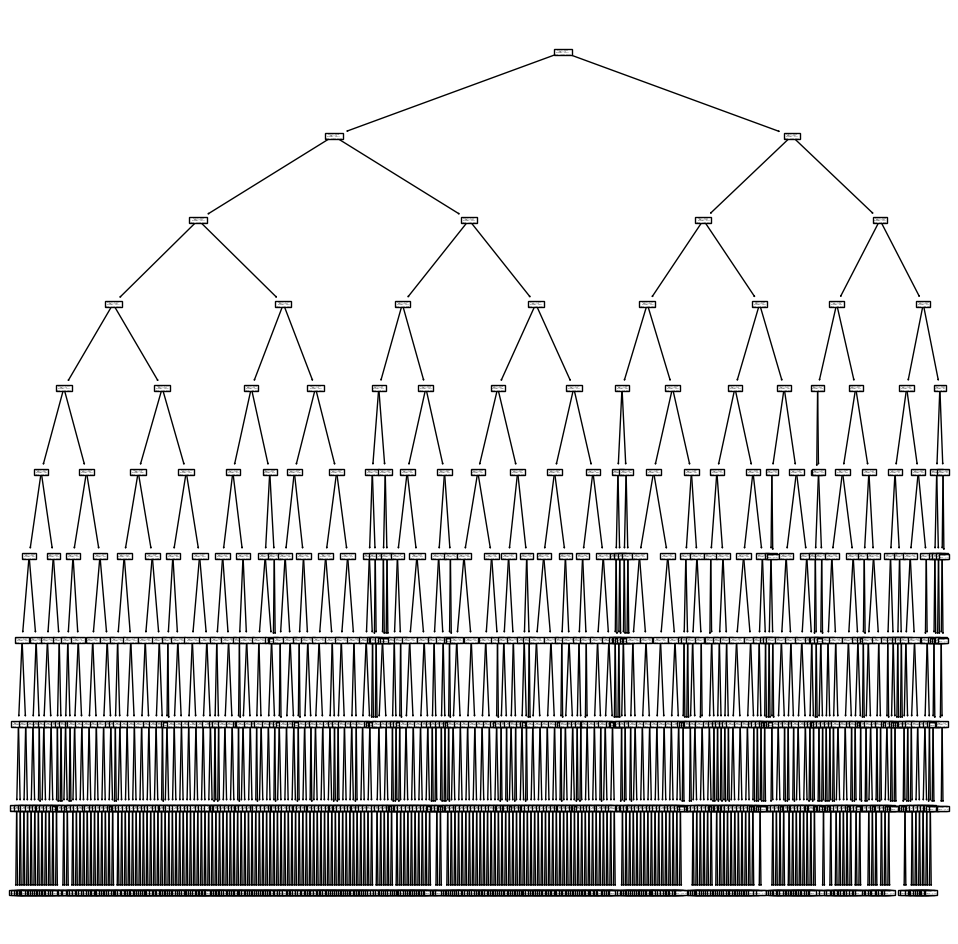

In [15]:
# Obtén el primer árbol de decisión del modelo de Random Forest
primer_arbol = random_forest.estimators_[0]

# Visualiza el árbol de decisión
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(primer_arbol, ax=ax)
plt.show()

## Predicción en el conjunto de entrenamiento y cálculo de la pérdida y precisión

In [16]:
y_train_pred = random_forest.predict(X_train)
train_loss = log_loss(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

## Predicción en el conjunto de prueba y cálculo de la pérdida y precisión


In [17]:
y_test_pred = random_forest.predict(X_test)
test_loss = log_loss(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


# Paso 7: Interpretación y análisis de los resultados

In [18]:
print("\nPérdida en el conjunto de entrenamiento:", train_loss)
print("Precisión en el conjunto de entrenamiento:", train_accuracy)
print("\nPérdida en el conjunto de prueba:", test_loss)
print("Precisión en el conjunto de prueba:", test_accuracy)


Pérdida en el conjunto de entrenamiento: 3.892714566024652
Precisión en el conjunto de entrenamiento: 0.892

Pérdida en el conjunto de prueba: 7.4141795021413985
Precisión en el conjunto de prueba: 0.7943


# Probar con una oracion

In [19]:
def classifySentiment(text):
    # Paso 1: Preprocesamiento del texto de entrada
    processed_text = vectorizer.transform([text])

    # Paso 2: Reducción de dimensionalidad utilizando SVD (LSA)
    text_lsa = lsa.transform(processed_text)

    # Paso 3: Clasificación de polaridad utilizando el modelo de Random Forest
    sentiment_label = random_forest.predict(text_lsa)
    sentiment = label_encoder.inverse_transform(sentiment_label)[0]

    # Paso 4: Devolución de la clasificación de polaridad
    return sentiment

## resultado

In [28]:
review_text = "“Spider-Man: Across the Spider-Verse” is the epitome of the complete art form. Films are a perfect collection of individual art forms....This movie is funny, engaging, masterfully animated and one of the best films ever made"
sentiment = classifySentiment(review_text)
print(review_text)
print("Sentiment:", sentiment)

“Spider-Man: Across the Spider-Verse” is the epitome of the complete art form. Films are a perfect collection of individual art forms....This movie is funny, engaging, masterfully animated and one of the best films ever made
Sentiment: positive
